In [1]:
##importing Basic libraries
import pandas as pd
import pickle
from pandas import DataFrame, Series
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
import numpy as np
import seaborn as sns
from sklearn import linear_model, naive_bayes
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeRegressor
from sklearn import svm
from matplotlib import pyplot
import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error,r2_score
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objects as go
import xgboost as xgb
from xgboost import XGBRegressor, XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam


In [54]:
df3 = pd.read_csv("Data/merged_data.csv",low_memory=False)

In [55]:
#Create a new dataframe with only the columns we want for Analysis
dft = df3[['Pitcher','PitcherTeam','TaggedPitchType','PitchCall','PlayResult','RelSpeed','SpinRate','RelHeight','RelSide','Extension','InducedVertBreak', 'HorzBreak','PlateLocHeight','PlateLocSide']]

In [56]:
#fastballs = 'Fastball', 'Sinker', 'TwoSeamFastBall', 'FourSeamFastBall', 'OneSeamFastBall'
dfb2 = dft[dft.TaggedPitchType.isin(['Fastball', 'Sinker', 'TwoSeamFastBall', 'FourSeamFastBall', 'OneSeamFastBall'])]
#sliders = 'Slider'
dsl2 = dft[dft.TaggedPitchType.isin(['Slider'])]
#curveballs = 'Curveball', 'KnuckleCurve'
dcb2 = dft[dft.TaggedPitchType.isin(['Curveball', 'KnuckleCurve'])]
#changeups = 'Changeup', 'Splitter', 'Forkball', 'Screwball'
dch2 = dft[dft.TaggedPitchType.isin(['ChangeUp','Splitter'])]



In [57]:
#create a new column called ABS_Horizontal with the absolute value of HorzBreak  in dfb2
dfb2['ABS_Horizontal'] = abs(dfb2['HorzBreak'])
dsl2['ABS_Horizontal'] = abs(dsl2['HorzBreak'])
dcb2['ABS_Horizontal'] = abs(dcb2['HorzBreak'])
dch2['ABS_Horizontal'] = abs(dch2['HorzBreak'])
#create a new column called ABS_relside with the absolute value of RelSide in dfb2
dfb2['ABS_RelSide'] = abs(dfb2['RelSide'])
dsl2['ABS_RelSide'] = abs(dsl2['RelSide'])
dcb2['ABS_RelSide'] = abs(dcb2['RelSide'])
dch2['ABS_RelSide'] = abs(dch2['RelSide'])
#create a new column called differential break which is the absolute value of InducedVertBreak - ABS_Horizontal
dfb2['differential_break'] = abs(dfb2['InducedVertBreak'] - dfb2['ABS_Horizontal'])
dsl2['differential_break'] = abs(dsl2['InducedVertBreak'] - dsl2['ABS_Horizontal'])
dcb2['differential_break'] = abs(dcb2['InducedVertBreak'] - dcb2['ABS_Horizontal'])
dch2['differential_break'] = abs(dch2['InducedVertBreak'] - dch2['ABS_Horizontal'])


C:\Users\maxim\AppData\Local\Temp\ipykernel_3448\3249499381.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\maxim\AppData\Local\Temp\ipykernel_3448\3249499381.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\maxim\AppData\Local\Temp\ipykernel_3448\3249499381.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-d

In [58]:
#delete all rows with nan values
dfb2 = dfb2.dropna()
dsl2 = dsl2.dropna()
dcb2 = dcb2.dropna()
dch2 = dch2.dropna()


In [59]:
#reset index    
dfb2 = dfb2.reset_index(drop=True)
dsl2 = dsl2.reset_index(drop=True)
dcb2 = dcb2.reset_index(drop=True)
dch2 = dch2.reset_index(drop=True)

In [60]:
#PitchCall unique values
dft['PitchCall'].unique()

array(['StrikeCalled', 'BallCalled', 'StrikeSwinging', 'Foul', 'InPlay',
       'HitByPitch', nan, 'FoulTip'], dtype=object)

In [61]:
#change 'SwinginStrike', 'StriekSwinging' in PitchCall to 'StrikeSwinging'
dft['PitchCall'] = dft['PitchCall'].replace(['SwinginStrike', 'StriekSwinging'], 'StrikeSwinging')

C:\Users\maxim\AppData\Local\Temp\ipykernel_3448\2683645860.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [62]:
#new dataframe with only PitchCall StrikeSwinging, InPlay, FoulBall and call it df_Swing
df_Swing = dft[(dft['PitchCall'] == 'StrikeSwinging') | (dft['PitchCall'] == 'InPlay') | (dft['PitchCall'] == 'FoulBall')]

In [63]:
#create a dummy variable for PitchCall with StrikeSwinging = 1 and InPlay, FoulBall = 0
df_Swing['Whiff'] = df_Swing['PitchCall'].replace(['StrikeSwinging'], 1)
df_Swing['Whiff'] = df_Swing['PitchCall'].replace(['InPlay', 'FoulBall'], 0)

C:\Users\maxim\AppData\Local\Temp\ipykernel_3448\2116572367.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\maxim\AppData\Local\Temp\ipykernel_3448\2116572367.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [64]:
#replace strike swinging with 1 and inplay, foulball with 0
df_Swing['Whiff'] = df_Swing['Whiff'].replace(['StrikeSwinging'], 1)

C:\Users\maxim\AppData\Local\Temp\ipykernel_3448\2166355664.py:2: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

C:\Users\maxim\AppData\Local\Temp\ipykernel_3448\2166355664.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [65]:
#create a new column called ABS_Horizontal with the absolute value of HorzBreak
df_Swing['ABS_Horizontal'] = abs(df_Swing['HorzBreak'])
#create a new column called ABS_RelSide with the absolute value of RelSide
df_Swing['ABS_RelSide'] = abs(df_Swing['RelSide'])

C:\Users\maxim\AppData\Local\Temp\ipykernel_3448\1567009961.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\maxim\AppData\Local\Temp\ipykernel_3448\1567009961.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [66]:
#create a new column called differential break which is the absolute value of InducedVertBreak - ABS_Horizontal
df_Swing['differential_break'] = abs(df_Swing['InducedVertBreak'] - df_Swing['ABS_Horizontal'])

C:\Users\maxim\AppData\Local\Temp\ipykernel_3448\2720128996.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [67]:
#taggedpitchtype unique values
df_Swing['TaggedPitchType'].unique()

array(['Slider', 'Fastball', 'Changeup', 'Curveball', 'Splitter',
       'Cutter', 'Sinker', nan], dtype=object)

In [68]:
#remove any row with Nan for any of the columns
df_Swing = df_Swing.dropna()
#reset the index
df_Swing = df_Swing.reset_index(drop=True)

In [69]:
#seperate dataframes for each pitch type 
#fastballs = 'Fastball', 'Sinker', 'TwoSeamFastBall', 'FourSeamFastBall', 'OneSeamFastBall'
df_Fastball = df_Swing[(df_Swing['TaggedPitchType'] == 'Fastball') | (df_Swing['TaggedPitchType'] == 'Sinker') | (df_Swing['TaggedPitchType'] == 'TwoSeamFastBall') | (df_Swing['TaggedPitchType'] == 'FourSeamFastBall') | (df_Swing['TaggedPitchType'] == 'OneSeamFastBall')]
df_Fastball = df_Fastball.reset_index(drop=True)

In [70]:
#curveballs = 'Curveball', 'KnuckleCurve'
df_Curveball = df_Swing[(df_Swing['TaggedPitchType'] == 'Curveball') | (df_Swing['TaggedPitchType'] == 'KnuckleCurve')]
df_Curveball = df_Curveball.reset_index(drop=True)

In [71]:
#df_Slider = 'Slider'
df_Slider = df_Swing[(df_Swing['TaggedPitchType'] == 'Slider')]
df_Slider = df_Slider.reset_index(drop=True)

In [72]:
#df_Changeup = 'Changeup'
df_Changeup = df_Swing[df_Swing['TaggedPitchType'].isin(['Changeup', 'Splitter'])]
df_Changeup = df_Changeup.reset_index(drop=True)

In [73]:
df_Swing.columns

Index(['Pitcher', 'PitcherTeam', 'TaggedPitchType', 'PitchCall', 'PlayResult',
       'RelSpeed', 'SpinRate', 'RelHeight', 'RelSide', 'Extension',
       'InducedVertBreak', 'HorzBreak', 'PlateLocHeight', 'PlateLocSide',
       'Whiff', 'ABS_Horizontal', 'ABS_RelSide', 'differential_break'],
      dtype='object')

In [74]:
#create the FB expected whiff rate
X = df_Fastball[['RelSpeed', 'SpinRate','differential_break','RelHeight', 'ABS_RelSide', 'Extension']]
y = df_Fastball['Whiff']

In [75]:
#create the CB expected whiff rate
X1 = df_Curveball[['RelSpeed', 'SpinRate', 'InducedVertBreak', 'ABS_Horizontal','RelHeight', 'ABS_RelSide', 'Extension']]
y1 = df_Curveball['Whiff']

In [76]:
#create the SL expected whiff rate
X2 = df_Slider[['RelSpeed', 'SpinRate', 'InducedVertBreak', 'ABS_Horizontal','RelHeight', 'ABS_RelSide', 'Extension']]
y2 = df_Slider['Whiff']

In [77]:
#create the CH expected whiff rate
X3 = df_Changeup[['RelSpeed', 'SpinRate', 'InducedVertBreak', 'ABS_Horizontal','RelHeight', 'ABS_RelSide', 'Extension']]
y3 = df_Changeup['Whiff']

In [78]:
X3.count

<bound method DataFrame.count of      RelSpeed     SpinRate  InducedVertBreak  ABS_Horizontal  RelHeight  \
0   82.437683  1746.430285         14.804227       14.613964   5.317848   
1   82.079798  2138.789982         16.661641       17.047536   5.772903   
2   82.688197  2165.823006         16.555451       16.995493   5.693972   
3   76.855481  2304.960189          2.114593       15.074470   4.661692   
4   81.141075  1688.361792          7.075199       19.390032   4.979251   
5   80.344017  1677.297875          6.507304       19.566677   5.070805   
6   79.566504  1731.306120          8.002241       19.643536   5.290399   
7   80.541143  1720.000690          8.104015       19.094804   5.347382   
8   82.260191  1749.871653          9.063716       19.032929   5.392075   
9   79.883398  1733.402693          7.494702       19.782361   5.076729   
10  74.874728  1344.239797          7.694170       17.352419   5.696693   
11  78.482152  1978.681053          4.994465        0.164091   4.83

In [79]:
#split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=101)

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.25, random_state=101)

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.25, random_state=101)

X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.25, random_state=101)



In [80]:
def train_model(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Create the neural network model
    model = Sequential()
    model.add(Dense(64, input_dim=X.shape[1], activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

    # Train the model
    model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32)

    return model

In [81]:
#xgboost for fastball
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [82]:
#random forest for fastball
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train, y_train)

RandomForestClassifier()

In [83]:
fastball_model = train_model(X, y)

Epoch 1/50


c:\Users\maxim\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.2537 - loss: 89.1723 - val_accuracy: 0.8590 - val_loss: 19.4676
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8793 - loss: 18.8489 - val_accuracy: 0.8590 - val_loss: 24.6307
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8690 - loss: 20.0816 - val_accuracy: 0.8590 - val_loss: 13.0157
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8364 - loss: 8.5086 - val_accuracy: 0.5385 - val_loss: 0.8567
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8275 - loss: 2.1670 - val_accuracy: 0.8590 - val_loss: 3.5212
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8120 - loss: 1.8308 - val_accuracy: 0.8590 - val_loss: 2.0516
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8138 - loss: 1.5210 - val_accuracy: 0.8590 - val_loss: 0.8173
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7994 - loss: 0.8882 - val_accuracy: 0.2949 - val_loss: 1.

In [84]:
#xgboost for curveball
xgb_model1 = XGBClassifier()
xgb_model1.fit(X1_train, y1_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [85]:
#random forest for curveball
rfc1 = RandomForestClassifier(n_estimators=100)
rfc1.fit(X1_train, y1_train)

RandomForestClassifier()

In [86]:
#CURVEBALL MODEL
curveball_model = train_model(X1, y1)

Epoch 1/50


c:\Users\maxim\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 265ms/step - accuracy: 0.7649 - loss: 34.2134 - val_accuracy: 0.6000 - val_loss: 30.7803
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.7649 - loss: 14.8014 - val_accuracy: 0.4000 - val_loss: 2.7561
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.2351 - loss: 3.9008 - val_accuracy: 0.4000 - val_loss: 1.4851
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.2531 - loss: 2.2567 - val_accuracy: 0.6000 - val_loss: 8.8544
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.7545 - loss: 4.6308 - val_accuracy: 0.6000 - val_loss: 10.0315
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.7545 - loss: 5.1210 - val_accuracy: 0.6000 - val_loss: 6.3115
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.7545 - loss: 3.0364 - val_accuracy: 0.4000 - val_loss: 1.9997
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.2455 - loss: 2.6176 - val_accuracy: 0.6000 - val_loss: 2.5121
Epoch 

In [87]:
#xgboost for slider
xgb_model2 = XGBClassifier()
xgb_model2.fit(X2_train, y2_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [88]:
#random forest for slider
rfc2 = RandomForestClassifier(n_estimators=100)
rfc2.fit(X2_train, y2_train)


RandomForestClassifier()

In [89]:
#SLIDER MODEL
slider_model = train_model(X2, y2)

Epoch 1/50


c:\Users\maxim\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 0.8826 - loss: 19.6858 - val_accuracy: 0.7647 - val_loss: 14.9857
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8415 - loss: 6.7544 - val_accuracy: 0.2353 - val_loss: 11.2052
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.4210 - loss: 8.1421 - val_accuracy: 0.7647 - val_loss: 10.4708
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8904 - loss: 5.0828 - val_accuracy: 0.7647 - val_loss: 17.4411
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8826 - loss: 7.8847 - val_accuracy: 0.7647 - val_loss: 18.0129
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.8826 - loss: 8.1658 - val_accuracy: 0.7647 - val_loss: 14.0108
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8904 - loss: 5.4813 - val_accuracy: 0.7647 - val_loss: 6.7448
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8709 - loss: 3.0347 - val_accuracy: 0.2353 - val_loss: 4.5429
Epo

In [90]:
#xgboost for changeup
xgb_model3 = XGBClassifier()
xgb_model3.fit(X3_train, y3_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [91]:
#random forest for changeup
rfc3 = RandomForestClassifier(n_estimators=100)
rfc3.fit(X3_train, y3_train)

RandomForestClassifier()

In [92]:
#CHANGEUP MODEL
changeup_model = train_model(X3, y3)

Epoch 1/50


c:\Users\maxim\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 294ms/step - accuracy: 0.7042 - loss: 7.1369 - val_accuracy: 1.0000 - val_loss: 3.5761e-04
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.7348 - loss: 2.7745 - val_accuracy: 1.0000 - val_loss: 5.3768e-07
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.7244 - loss: 4.8084 - val_accuracy: 1.0000 - val_loss: 0.0170
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7042 - loss: 1.5395 - val_accuracy: 0.4444 - val_loss: 1.1558
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.5101 - loss: 1.2997 - val_accuracy: 1.0000 - val_loss: 6.9010e-04
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.7244 - loss: 2.4573 - val_accuracy: 1.0000 - val_loss: 5.2066e-05
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.7348 - loss: 3.1325 - val_accuracy: 1.0000 - val_loss: 0.1608
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.6938 - loss: 0.8781 - val_accuracy: 0.0000e+00 - val_lo

In [93]:
#find rmse for fastball
predictions = xgb_model.predict(X_test)
print('XGBoost Fastball RMSE:', np.sqrt(mean_squared_error(y_test, predictions)))

XGBoost Fastball RMSE: 0.3517262290563295


In [94]:
#find rmse for fastball
predictions = rfc.predict(X_test)
print('Random Forest Fastball RMSE:', np.sqrt(mean_squared_error(y_test, predictions)))

Random Forest Fastball RMSE: 0.32108064953396775


In [95]:
#find rmse for Fastball nn
predictions = fastball_model.predict(X_test)
print('Neural Network Fastball RMSE:', np.sqrt(mean_squared_error(y_test, predictions)))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Neural Network Fastball RMSE: 0.8804993987624133


In [96]:
#create a new column in the dfb2 dataframe called xWhiff_xg and set it equal to the predicted probability of a whiff as predicted by the xgboost model
dfb2['xWhiff_xg'] = xgb_model.predict_proba(dfb2[['RelSpeed', 'SpinRate', 'differential_break', 'RelHeight', 'ABS_RelSide', 'Extension']])[:,1]


In [97]:
#create a new column in the dfb2 dataframe called xWhiff_xg and set it equal to the predicted probability of a whiff as predicted by the xgboost model
dcb2['xWhiff_xg'] = xgb_model1.predict_proba(dcb2[['RelSpeed', 'SpinRate', 'InducedVertBreak', 'ABS_Horizontal','RelHeight', 'ABS_RelSide', 'Extension']])[:,1]

In [98]:
#create a new column in the dsl2 dataframe called xWhiff and use the model tp predict the expected whiff rate given the same variables
dsl2['xWhiff_xg'] = xgb_model2.predict_proba(dsl2[['RelSpeed', 'SpinRate', 'InducedVertBreak', 'ABS_Horizontal','RelHeight', 'ABS_RelSide', 'Extension']])[:,1]

In [99]:
#create a new column in the dch2 dataframe called xWhiff and use the model tp predict the expected whiff rate given the same variables
dch2['xWhiff_xg'] = xgb_model3.predict_proba(dch2[['RelSpeed', 'SpinRate', 'InducedVertBreak', 'ABS_Horizontal','RelHeight', 'ABS_RelSide', 'Extension']])[:,1]

In [100]:
#create a new column in the dfb2 dataframe called xWhiff_rf and set it equal to the predicted probability of a whiff as predicted by the random forest model
dfb2['xWhiff_rf'] = rfc.predict_proba(dfb2[['RelSpeed', 'SpinRate', 'differential_break', 'RelHeight', 'ABS_RelSide', 'Extension']])[:,1]


In [101]:
#create a new column in the dfb2 dataframe called xWhiff_rf and set it equal to the predicted probability of a whiff as predicted by the random forest model
dcb2['xWhiff_rf'] = rfc1.predict_proba(dcb2[['RelSpeed', 'SpinRate', 'InducedVertBreak', 'ABS_Horizontal','RelHeight', 'ABS_RelSide', 'Extension']])[:,1]

In [102]:
#create a new column in the dsl2 dataframe called xWhiff and use the model tp predict the expected whiff rate given the same variables
dsl2['xWhiff_rf'] = rfc2.predict_proba(dsl2[['RelSpeed', 'SpinRate', 'InducedVertBreak', 'ABS_Horizontal','RelHeight', 'ABS_RelSide', 'Extension']])[:,1]

In [103]:
#create a new column in the dch2 dataframe called xWhiff and use the model tp predict the expected whiff rate given the same variables
dch2['xWhiff_rf'] = rfc3.predict_proba(dch2[['RelSpeed', 'SpinRate', 'InducedVertBreak', 'ABS_Horizontal','RelHeight', 'ABS_RelSide', 'Extension']])[:,1]

In [104]:
#USE NEURAL NETWORK TO PREDICT WHIFF RATE FOR FASTBALL AND ADD TO DATAFRAME
dfb2['xWhiff_nn'] = fastball_model.predict(dfb2[['RelSpeed', 'SpinRate', 'differential_break', 'RelHeight', 'ABS_RelSide', 'Extension']])

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


In [105]:
#USE NEURAL NETWORK TO PREDICT WHIFF RATE FOR CURVEBALL AND ADD TO DATAFRAME
dcb2['xWhiff_nn'] = curveball_model.predict(dcb2[['RelSpeed', 'SpinRate', 'InducedVertBreak', 'ABS_Horizontal','RelHeight', 'ABS_RelSide', 'Extension']])

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


In [106]:
#USE NEURAL NETWORK TO PREDICT WHIFF RATE FOR SLIDER AND ADD TO DATAFRAME
dsl2['xWhiff_nn'] = slider_model.predict(dsl2[['RelSpeed', 'SpinRate', 'InducedVertBreak', 'ABS_Horizontal','RelHeight', 'ABS_RelSide', 'Extension']])

1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/stepWARNING:tensorflow:5 out of the last 22 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000001AF797C3400> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


In [107]:
#USE NEURAL NETWORK TO PREDICT WHIFF RATE FOR CHANGEUP AND ADD TO DATAFRAME
dch2['xWhiff_nn'] = changeup_model.predict(dch2[['RelSpeed', 'SpinRate', 'InducedVertBreak', 'ABS_Horizontal','RelHeight', 'ABS_RelSide', 'Extension']])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


In [108]:
#take the average of the Three models to get the final expected whiff rate
dfb2['xWhiff'] = (dfb2['xWhiff_xg'] + dfb2['xWhiff_rf'] + dfb2['xWhiff_nn'])/3
dcb2['xWhiff'] = (dcb2['xWhiff_xg'] + dcb2['xWhiff_rf'] + dcb2['xWhiff_nn'])/3
dsl2['xWhiff'] = (dsl2['xWhiff_xg'] + dsl2['xWhiff_rf'] + dsl2['xWhiff_nn'])/3
dch2['xWhiff'] = (dch2['xWhiff_xg'] + dch2['xWhiff_rf'] + dch2['xWhiff_nn'])/3

In [109]:
#find the mean of the xWhiff column
dfb2['xWhiff'].mean()

0.3901033919580815

In [110]:
#find the mean of the xWhiff column
dcb2['xWhiff'].mean()

0.5364029500309645

In [111]:
#find the mean of the xWhiff column
dsl2['xWhiff'].mean()

0.14422342036397373

In [112]:
#find the mean of the xWhiff column
dch2['xWhiff'].mean()

0.07442604709129472

In [113]:
#create a new column in dfb2 called stuff+ which is (xWhiff / mean of xWhiff for dfb2) * 100
dfb2['stuff+'] = (dfb2['xWhiff'] / dfb2['xWhiff'].mean()) * 100
#create a new column in dcb2 called stuff+ which is (xWhiff / mean of xWhiff for dcb2) * 100
dcb2['stuff+'] = (dcb2['xWhiff'] / dcb2['xWhiff'].mean()) * 100
#create a new column in dsl2 called stuff+ which is (xWhiff / mean of xWhiff for dsl2) * 100
dsl2['stuff+'] = (dsl2['xWhiff'] / dsl2['xWhiff'].mean()) * 100
#create a new column in dch2 called stuff+ which is (xWhiff / mean of xWhiff for dch2) * 100
dch2['stuff+'] = (dch2['xWhiff'] / dch2['xWhiff'].mean()) * 100

In [114]:
#find correlation between each xWhiff and stuff+ column
dfb2['xWhiff_nn'].corr(dfb2['stuff+'])

0.3799623050753883

In [115]:
#calulcate the mean of stuff+ for dfb2
dfb2['stuff+'].mean()

99.99999999999999

In [116]:
#calulcate the mean of stuff+ for dcb2
dcb2['stuff+'].mean()

100.0

In [117]:
#calulcate the mean of stuff+ for dsl2
dsl2['stuff+'].mean()


100.00000000000001

In [118]:
#calulcate the mean of stuff+ for dch2
dch2['stuff+'].mean()

99.99999999999999

<BarContainer object of 4 artists>

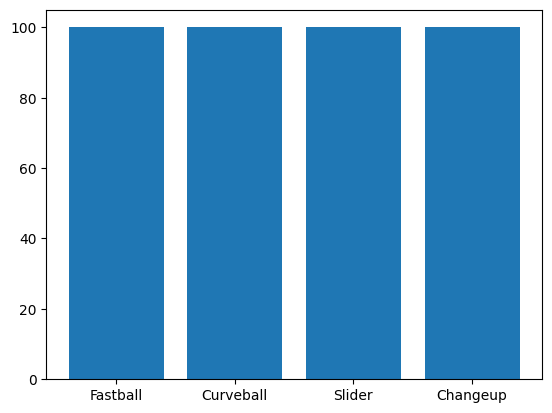

In [119]:
#creat a visualization of the mean of stuff+ for each pitch type 
plt.bar(['Fastball', 'Curveball', 'Slider', 'Changeup'], [dfb2['stuff+'].mean(), dcb2['stuff+'].mean(), dsl2['stuff+'].mean(), dch2['stuff+'].mean()])


In [120]:
#reccombine the dataframes
College_Final_Stuff = pd.concat([dfb2, dsl2, dcb2, dch2], ignore_index=True)

In [121]:
College_Final_Stuff

Pitcher            PitcherTeam TaggedPitchType       PitchCall  \
0    Samuel Guadamuz      Rex baseball 2025        Fastball          InPlay   
1    Samuel Guadamuz      Rex baseball 2025        Fastball          InPlay   
2    Samuel Guadamuz      Rex baseball 2025        Fastball          InPlay   
3         Rj Bergren     Normal cornbelters        Fastball  StrikeSwinging   
4         Rj Bergren     Normal cornbelters        Fastball          InPlay   
..               ...                    ...             ...             ...   
634    Zach Leuschen   Burlington bees 2025        Splitter  StrikeSwinging   
635         Ab Trier     Danville dans 2025        Splitter          InPlay   
636         Ab Trier     Danville dans 2025        Splitter          InPlay   
637     Devan Tupper  Kcl groundsloths 2025        Splitter          InPlay   
638    Brett Granger     Kcl merchants 2025        Splitter          InPlay   

            PlayResult   RelSpeed     SpinRate  RelHeight   RelSide  \
0                  Out  83.747936  2157.399003   5.590344  4.158423   
1                  Out  89.071212  2141.345973   5.256668  2.914676   
2                  Out  89.370579  2173.052825   5.664889  3.397011   
3    StrikeoutSwinging  88.088280  2324.829918   5.219541  0.758672   
4                  Out  87.065017  2328.140039   5.035475  0.466773   
..                 ...        ...          ...        ...       ...   
634  StrikeoutSwinging  70.296943  1385.137657   5.176068 -2.085633   
635                Out  77.707644   866.948505   5.294981  2.795740   
636             Single  77.516673   844.614097   5.031740  3.747129   
637             Single  77.087252  2085.848824   5.358140  2.174936   
638                Out  65.082120  1011.628864   5.935922  2.741158   

     Extension  ...  PlateLocHeight  PlateLocSide  ABS_Horizontal  \
0          6.0  ...        1.867057      1.049992       14.371757   
1          6.0  ...        2.095018     -0.249994       14.956144   
2          6.0  ...        2.329352     -0.340112       13.805704   
3          6.0  ...        3.714265     -0.339573        9.070179   
4          6.0  ...        2.850631     -0.074831        9.084601   
..         ...  ...             ...           ...             ...   
634        6.0  ...        2.231392      1.527230       15.352559   
635        6.0  ...        1.983099     -1.351933        9.118649   
636        6.0  ...        2.924715      0.339537        9.110352   
637        6.0  ...        2.794226     -0.786913        0.225714   
638        6.0  ...        2.479037     -0.534164        3.769685   

     ABS_RelSide  differential_break  xWhiff_xg  xWhiff_rf  xWhiff_nn  \
0       4.158423            4.963272   0.010781       0.03   0.998640   
1       2.914676            2.322386   0.000751       0.00   0.994413   
2       3.397011            4.274694   0.013912       0.03   0.996230   
3       0.758672            6.906795   0.913629       0.61   0.999202   
4       0.466773            6.900633   0.718482       0.42   0.999336   
..           ...                 ...        ...        ...        ...   
634     2.085633            8.394110   0.350442       0.31   0.004241   
635     2.795740            8.005491   0.005638       0.01   0.000426   
636     3.747129            9.089382   0.008154       0.06   0.000263   
637     2.174936            2.214007   0.006672       0.10   0.171028   
638     2.741158           11.630538   0.024269       0.01   0.055257   

       xWhiff      stuff+  
0    0.346474   88.815853  
1    0.331721   85.034214  
2    0.346714   88.877455  
3    0.840944  215.569418  
4    0.712606  182.671077  
..        ...         ...  
634  0.221561  297.692666  
635  0.005355    7.194758  
636  0.022806   30.642088  
637  0.092567  124.374236  
638  0.029842   40.096253  

[639 rows x 22 columns]

In [122]:
College_Final_Stuff.to_csv('out.csv',index=False)